In [1]:
# Importing necessary libraries and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import warnings

In [3]:
# Importing data

train = pd.read_csv('train.csv', parse_dates=['date'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [4]:
test = pd.read_csv('test.csv', parse_dates=['date'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int64         
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB


In [7]:
sample_submission=pd.read_csv('sample_submission.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int64         
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB


In [9]:
# Combining the train and test data beacause we are creating some features which are common

df = pd.concat([train, test])
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [10]:
df.tail()

,date,store,item,sales,id
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0
44999,2018-03-31,10,50,NaN,44999.0


In [11]:
# To find the null values in data df

df.isnull().sum()

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

In [12]:
# To see the statistical characteristics of sales column

df["sales"].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

In [15]:
# To find the start and end dates of train and test data

train['date'].min(), train['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [16]:
test['date'].min(), test['date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [17]:
# To find the number of stores, number of items and number of items per store

df['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [18]:
df['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [21]:
df.groupby(['store'])['item'].unique()

store
1     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
2     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
3     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
4     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
6     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
7     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
8     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
9     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
10    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Name: item, dtype: object

In [22]:
# To find the number each items sold per store in train data

df.groupby(['store', 'item']).agg({'sales': ['sum']})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [23]:
# Creating new features from date column to convert time series problem to regression problem and find seasonality

def date_features(df):
    df['month']=df.date.dt.month
    df['day_of_month']=df.date.dt.day
    df['year']=df.date.dt.year
    df['week_of_year']=df.date.dt.weekofyear
    df['day_of_year']=df.date.dt.dayofyear
    df['day_of_week']=df.date.dt.dayofweek
    df['is_wknd']=df.date.dt.weekday // 4
    df['is_month_start']=df.date.dt.is_month_start.astype(int)
    df['is_month_end']=df.date.dt.is_month_end.astype(int)
    return df

In [24]:
df=date_features(df)
df.head()

C:\Users\SAM\AppData\Local\Temp\ipykernel_9528\3372866916.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year']=df.date.dt.weekofyear


,date,store,item,sales,id,month,day_of_month,year,week_of_year,day_of_year,day_of_week,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,1,1,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2013,1,2,2,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,2013,1,3,3,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,2013,1,4,4,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,2013,1,5,5,1,0,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            958000 non-null  datetime64[ns]
 1   store           958000 non-null  int64         
 2   item            958000 non-null  int64         
 3   sales           913000 non-null  float64       
 4   id              45000 non-null   float64       
 5   month           958000 non-null  int64         
 6   day_of_month    958000 non-null  int64         
 7   year            958000 non-null  int64         
 8   week_of_year    958000 non-null  int64         
 9   day_of_year     958000 non-null  int64         
 10  day_of_week     958000 non-null  int64         
 11  is_wknd         958000 non-null  int64         
 12  is_month_start  958000 non-null  int32         
 13  is_month_end    958000 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int

In [26]:
# To see the per month sales statistics of each item and store

df.groupby(['store', 'item', 'month']).agg({'sales': ['sum', 'mean', 'std']})

sales                      
                      sum       mean        std
store item month                               
1     1    1       2125.0  13.709677   4.397413
           2       2063.0  14.631206   4.668146
           3       2728.0  17.600000   4.545013
           4       3118.0  20.786667   4.894301
           5       3448.0  22.245161   6.564705
...                   ...        ...        ...
10    50   8      13108.0  84.567742  15.676527
           9      11831.0  78.873333  15.207423
           10     11322.0  73.045161  14.209171
           11     11549.0  76.993333  16.253651
           12      8724.0  56.283871  11.782529

[6000 rows x 3 columns]

In [27]:
df.groupby(["store", "item"])[['store', 'item', 'date', 'sales']].head()

,store,item,date,sales
0,1,1,2013-01-01,13.0
1,1,1,2013-01-02,11.0
2,1,1,2013-01-03,14.0
3,1,1,2013-01-04,13.0
4,1,1,2013-01-05,10.0
...,...,...,...,...
911174,10,50,2013-01-01,33.0
911175,10,50,2013-01-02,37.0
911176,10,50,2013-01-03,46.0
911177,10,50,2013-01-04,51.0


In [28]:
# sorting data by store and item

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [29]:
# Creating Lag/shifted features for sale

pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


In [30]:
df.groupby(["store", "item"])[['sales']].transform(lambda x: x.shift(1))

,sales
0,NaN
1,13.0
2,11.0
3,14.0
4,13.0
...,...
44995,NaN
44996,NaN
44997,NaN
44998,NaN


In [32]:
# Adding Gaussian random noise to avoid overfitting

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [33]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [34]:
# Lag List

lags_list = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728] 
df = lag_features(df, lags_list)

In [35]:
df.head()

,date,store,item,sales,id,month,day_of_month,year,week_of_year,day_of_year,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2013,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,2013,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,2013,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,2013,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df.tail()

,date,store,item,sales,id,month,day_of_month,year,week_of_year,day_of_year,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,2018,13,86,...,40.714274,55.024941,66.050027,66.866807,69.762551,80.148216,79.088021,59.089936,96.608905,71.226973
44996,2018-03-28,10,50,NaN,44996.0,3,28,2018,13,87,...,62.887688,50.291147,66.982893,60.858282,76.088950,83.436012,80.521276,74.917206,81.576273,65.732853
44997,2018-03-29,10,50,NaN,44997.0,3,29,2018,13,88,...,60.065263,63.566770,72.331257,63.721194,72.882568,88.321668,83.955575,65.547714,98.251646,76.294362
44998,2018-03-30,10,50,NaN,44998.0,3,30,2018,13,89,...,73.906944,74.731778,74.308470,67.308529,65.272798,80.644317,90.544633,68.932299,78.641476,82.153184
44999,2018-03-31,10,50,NaN,44999.0,3,31,2018,13,90,...,64.193841,72.561035,49.711167,70.635157,50.175026,77.998782,103.341422,101.617549,99.678150,82.066619


In [37]:
# Simple moving average

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


In [39]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

roll_mean_list = [365, 546]
df = roll_mean_features(df, roll_mean_list)
df.tail()

,date,store,item,sales,id,month,day_of_month,year,week_of_year,day_of_year,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,27,2018,13,86,...,66.050027,66.866807,69.762551,80.148216,79.088021,59.089936,96.608905,71.226973,91.286447,87.320064
44996,2018-03-28,10,50,NaN,44996.0,3,28,2018,13,87,...,66.982893,60.858282,76.088950,83.436012,80.521276,74.917206,81.576273,65.732853,86.852965,89.377133
44997,2018-03-29,10,50,NaN,44997.0,3,29,2018,13,88,...,72.331257,63.721194,72.882568,88.321668,83.955575,65.547714,98.251646,76.294362,90.342829,86.784674
44998,2018-03-30,10,50,NaN,44998.0,3,30,2018,13,89,...,74.308470,67.308529,65.272798,80.644317,90.544633,68.932299,78.641476,82.153184,88.871500,88.647606
44999,2018-03-31,10,50,NaN,44999.0,3,31,2018,13,90,...,49.711167,70.635157,50.175026,77.998782,103.341422,101.617549,99.678150,82.066619,91.339171,81.827694


In [40]:
# Exponential moving average

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10], 
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm01": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,sales,roll2,ewm099,ewm095,ewm07,ewm01
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


In [41]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe
 
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.head()

,date,store,item,sales,id,month,day_of_month,year,week_of_year,day_of_year,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2013,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,2013,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,2013,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,2013,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# One hot encoding

df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

In [43]:
df.head()

,date,sales,id,day_of_month,year,week_of_year,day_of_year,is_wknd,is_month_start,is_month_end,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,2013,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0,NaN,2,2013,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0,NaN,3,2013,1,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0,NaN,4,2013,1,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10.0,NaN,5,2013,1,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Standardization of target variable

df['sales']=np.log1p(df["sales"].values)

In [49]:
# Cost function

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [50]:
# Taking out validation set from training set

train = df.loc[(df["date"] < "2017-01-01"), :] # Until beginning of 2017
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :] # First 3 months of 2017

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [51]:
# Lightgbm model

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 11000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [53]:
# Training and prediction on validation set

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)  

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.169732 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	training's l1: 0.142409	training's SMAPE: 14.585	valid_1's l1: 0.145305	valid_1's SMAPE: 14.9057
[400]	training's l1: 0.134605	training's SMAPE: 13.8047	valid_1's l1: 0.139194	valid_1's SMAPE: 14.294
[600]	training's l1: 0.132305	training's SMAPE: 13.5751	valid_1's l1: 0.136702	valid_1's SMAPE: 14.0435
[800]	training's l1: 0.131003	training's SMAPE: 13.445	valid_1's l1: 0.135463	valid_1's SMAPE: 13.9188
[1000]	training's l1: 0.130094	training's SMAPE: 13.3539	valid_1's l1: 0.134681	valid_1's SMAPE: 13.84
[1200]	training's l1: 0.129435	training's SMAPE: 13.2877	valid_1's l1: 0.134095	valid_1's SMAPE: 13.781
[1400]	training's l1: 0.12892	training's SMAPE: 13.2359	valid_1's l1: 0.133711	valid_1's SMAPE: 13.7423
[1600]	training's l1: 0.128502	training's SMAPE: 

13.527375451920241

In [54]:
# Feature importance

def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

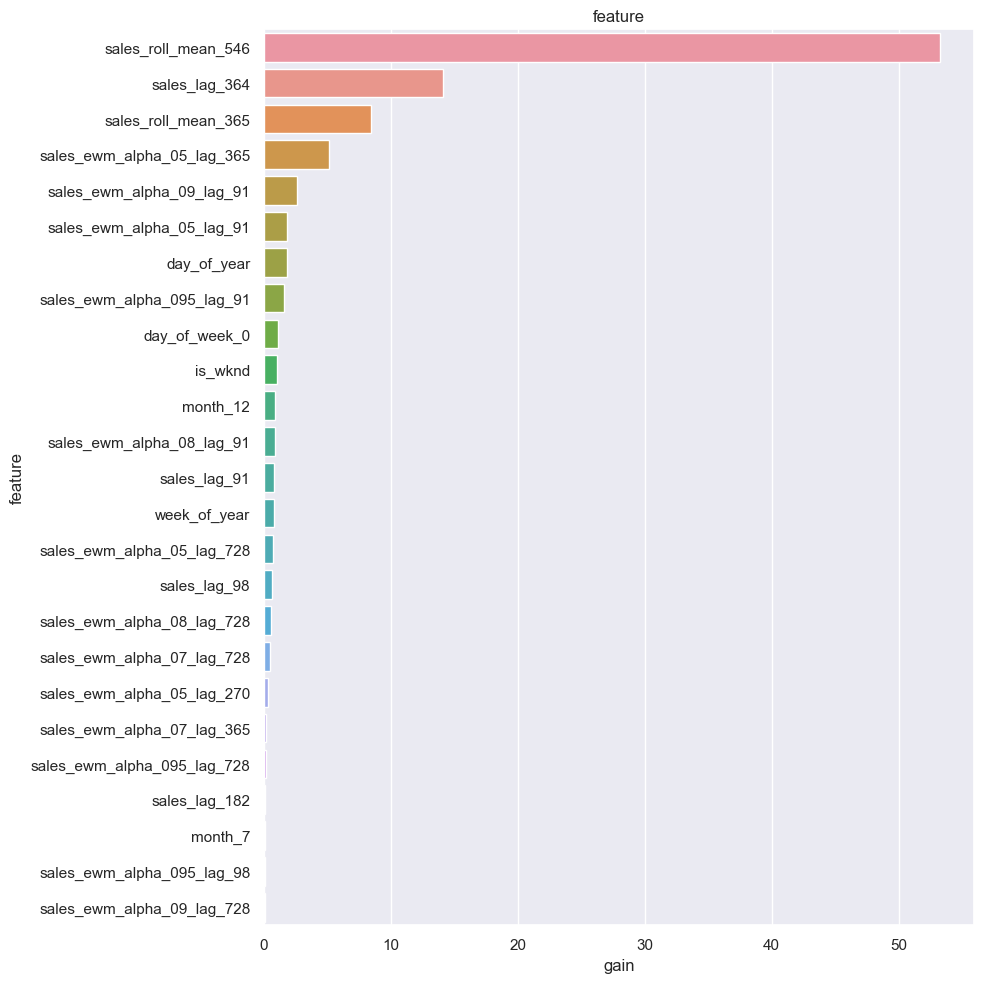

In [57]:
plot_lgb_importances(model, num=25, plot=True)

In [56]:
# Training and prediction on test set

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.486870 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [62]:
test_preds

array([2.56027516, 2.6849056 , 2.70213426, ..., 4.39154947, 4.44628155,
       4.45105447])

In [110]:
test_sales=np.expm1(test_preds)

In [111]:
test_sales

array([11.93937728, 13.65681776, 13.91152284, ..., 79.76546615,
       84.30913613, 84.717283  ])